In [1]:

import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splat
from popsims.relations import polynomial_relation
from splat.photometry import filterMag
import splat.empirical as spe
from tqdm import tqdm
import popsims
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u
from matplotlib.lines import Line2D
plot_style()
%matplotlib inline




Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [8]:
AREA=18_000*u.degree**2

#filenames
FILENAMES={'Rubin Wide': 'rubin_wide',  'Rubin 10 year': 'rubin_10year'}

#add additional selection
SURVEY_DEPTHS= {
       'Rubin Wide': {'LSST_G': 25., 'LSST_R': 24.7, 'LSST_I': 24.0, 'LSST_Z': 23.3, 'LSST_Y': 22.1}, 
       'Rubin 10 year': {'LSST_G': 25.3, 'LSST_R': 25.6, 'LSST_I': 25.4, 'LSST_Z': 24.9, 'LSST_Y': 24.}, 
}

linestyles={'thin disk': '-', 'thick disk': '-.', 'halo': 'dotted'}
scl={'thin disk': 1, 'thick disk': 0.12, 'halo':0.005}


selection0="LSST_G < 25.0 and LSST_R < 24.7 and LSST_I< 24.0 and LSST_Z < 23.3 and LSST_Y < 22.1"
color_selection="rz>2 and gz>2 and zy >1"
proper_motion_cuts= 'proper_motion > 1 and parallax > 3'
selection0=selection0+ 'and '+proper_motion_cuts
selection= selection0+'and '+ color_selection 
selection10year= selection0+'and '+ color_selection 


In [20]:
def compute_vols_and_numbers(data, population, selection=None):
    counts={}
    selection_function={}
    pointings=list(data['volume'][population][0].keys())
    drho=(AREA/len(data['footprint'])).to(u.radian**2)
    sptgrid=data['sptgrid']
    
    for idx, spt in enumerate(sptgrid):
        #compute selection correction by pointing
        n=0.0
        slfx={}
        for p in pointings:
            #compute simulated number of types
            select='spt >{} and spt < {}'.format(spt, spt+0.9)
            
            #compute local density (only depends on type)
            lcdens=(df.scale*len(df.query(select))).mean()
            
            #select on pointing
            #print (p)
            select= select+'and '+'pointing == {}'.format(p)
            nsim=df.query(select)
            
            #add additional_selection
            if selection is not None:
                select = select+'and '+ selection
                
            nselected= df.query(select)
            #compute total selection function
            
            tot_selection=(nselected/nsim)
            v=data['volume'][population][idx][p]*tot_selection*lcdens*drho
            
            n += v.value
            slfx.update({p: tot_selection})
            
    
        counts.update({spt: {'number':n}})
        selection_function.update({spt: slfx})
        
    fn=pd.DataFrame.from_records(counts).T
    fn['spt']=sptgrid
    return fn, selection_function


In [10]:
data_dicts={}
for k in FILENAMES.keys():
    data=np.array(np.load('../simulations{}.npy'.format(FILENAMES[k]),allow_pickle=True)).flatten()[0]
    #compute 
    df=data['data']
    df['gr']= df.LSST_G-df.LSST_R
    df['ri']= df.LSST_R-df.LSST_I
    df['rz']= df.LSST_R-df.LSST_Z
    df['iz']= df.LSST_I-df.LSST_Z
    df['gz']= df.LSST_G-df.LSST_Z
    df['zy']= df.LSST_Z-df.LSST_Y
    df['proper_motion']=(df.mu_delta**2+df.mu_alpha_cosdec**2)**0.5 #proper motion in mas/yr
    df['parallax']= 1000/df.distance
    data['data']=df
    data_dicts[k]= data
    


-5828819212433275655


SyntaxError: Python keyword not valid identifier in numexpr query (<unknown>, line 1)

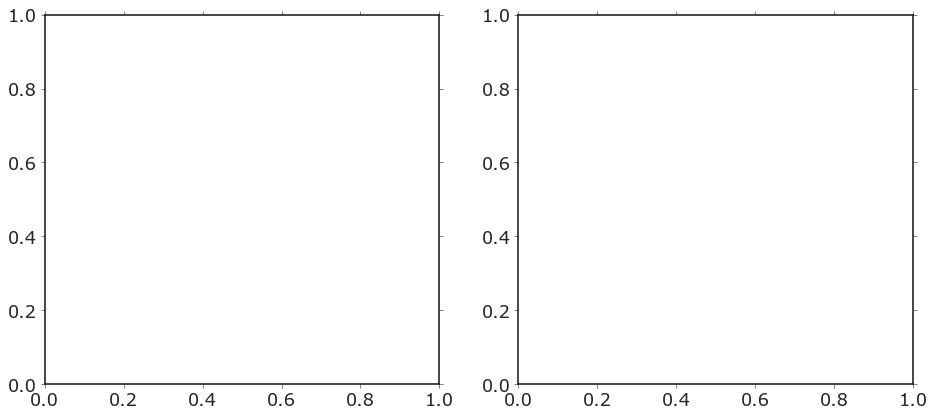

In [19]:
fig, ax=plt.subplots(ncols=2, figsize=(14, 6))
survey='Rubin Wide'
for pop in ['thin disk', 'thick disk', 'halo']:
    f= scl[pop]
    ns=compute_vols_and_numbers(data, pop, selection=selection0)[0]
    ns0=compute_vols_and_numbers(data,pop, selection=selection)[0]
    ax[0].step(ns.spt, f*ns.number, linestyle=linestyles[pop], color='k')
    ax[0].step(ns0.spt, f*ns0.number,  linestyle=linestyles[pop], color='#0074D9')

survey='Rubin 10 year'
for pop in ['thin disk', 'thick disk', 'halo']:
    f= scl[pop]
    ns=compute_vols_and_numbers(data, pop, selection=selection0)[0]
    ns0=compute_vols_and_numbers(data,pop, selection=selection10year)[0]
    ax[1].step(ns.spt, f*ns.number, linestyle=linestyles[pop], color='k')
    ax[1].step(ns0.spt, f*ns0.number,  linestyle=linestyles[pop], color='#0074D9')

for a in ax:
    a.set(xticks=[15,20, 25, 30, 35], xticklabels=['M5', 'L0', 'L5', 'T0', 'T5'],\
          xlim=[14, 40], yscale='log', ylabel='Number Counts')
    
    legend_elements = [Line2D([0], [0], color='#0074D9', ls='-',lw=2, label='Thin Disk + Color Selection'),
                       Line2D([0], [0], color='#0074D9', ls='-.',lw=2, label='Thick Disk + Color Selection'),
                       Line2D([0], [0], color='#0074D9', ls='dotted',lw=2, label='Halo + Color Selection'),
                       Line2D([0], [0], color='k', ls='-',lw=2, label='Thin Disk '),
                       Line2D([0], [0], color='k', ls='-.',lw=2, label='Thick Disk '),
                       Line2D([0], [0], color='k', ls='dotted',lw=2, label='Halo ')]

    a.legend(handles=legend_elements, loc='upper right', fontsize=14)

ax[0].set_title('Baseline Survey')
ax[1].set_title('10 Year Survey')
plt.savefig('../figures/lsst_baseline_number.pdf')

In [12]:
#now do scaleheights

In [13]:
#now do IMF 